<a href="https://colab.research.google.com/github/nahumsa/DM-Reconstruction/blob/master/Autoencoder%20Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder Benchmark

## Import dependencies for Google Colab

In [ ]:
! git clone https://github.com/nahumsa/DM-Reconstruction

In [ ]:
!pip install qutip

In [ ]:
% cd DM-Reconstruction/

## Import Dependencies

In [4]:
try:
  %tensorflow_version 2.x

except Exception:
  pass
  
import tensorflow as tf

#Set Random Seed for reproduction
tf.random.set_seed(1234)

import numpy as np
from tensorflow.keras import layers
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Remove warnings
import logging
logging.getLogger('tensorflow').disabled = True

#Use this to not need to initialize tensors outside session
tf.config.experimental_run_functions_eagerly(True)

In [5]:
%load_ext autoreload
%autoreload 2

## Loading Dataset

In [6]:
X_train = np.loadtxt('Data/Measurements/X_train.txt')
X_test = np.loadtxt('Data/Measurements/X_test.txt')

# Model

## 1) Using a simple AutoEncoder with a Mean Squared Error

In [21]:
from Models.AE import AutoEncoder
latent_dim = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32
dropout_rate=0.3

AE = AutoEncoder(original_dim=input_dim, 
            intermediate_dim= hidden_dims,
            latent_dim=latent_dim,
            dropout_rate=dropout_rate)

AE.compile(optimizer="adam", loss="mse", metrics=["mae"])

In [ ]:
from Utils.QMetrics import fidelity_rho

epochs = 10
loss_epochs = []
val_loss_epochs = []
fidelity_epochs = []
val_fidelity_epochs = []

for _ in range(epochs):
  history = AE.fit(x=X_train,
                   y=X_train, 
                   epochs=1,                                                                                   
                   validation_data=(X_test,X_test)
                  )
  loss_epochs.append(history.history['loss'][0])
  val_loss_epochs.append(history.history['val_loss'][0])

  fid = []
  with tqdm(total=len(X_train)) as pbar:  
    for val_1, val_2 in zip(X_train, AE.predict(X_train)):
      fid.append(fidelity_rho(val_1,val_2))
      pbar.update(1)
  fidelity_epochs.append(np.mean(fid))

  val_fid = []
  with tqdm(total=len(X_test)) as pbar:
    for val_1, val_2 in zip(X_test, AE.predict(X_test)):
      val_fid.append(fidelity_rho(val_1,val_2))
      pbar.update(1)
  val_fidelity_epochs.append(np.mean(val_fid))

In [23]:
# Saving results
save = False
if save:
  np.savetxt('Results/AE/AE_Fidelity.txt', fidelity_epochs)
  np.savetxt('Results/AE/AE_Loss.txt', loss_epochs)
  np.savetxt('Results/AE/val_AE_Fidelity.txt', val_fidelity_epochs)
  np.savetxt('Results/AE/val_AE_Loss.txt', val_loss_epochs)

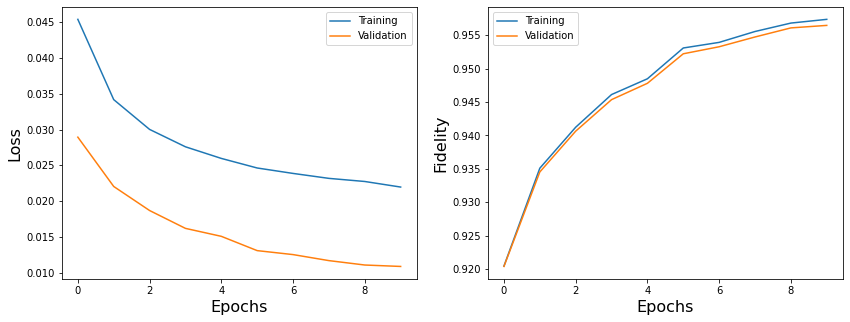

In [31]:
epochs = range(len(loss_epochs))

fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs,loss_epochs, label='Training')
ax1.plot(epochs,val_loss_epochs, label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs,fidelity_epochs, label='Training')
ax2.plot(epochs,val_fidelity_epochs, label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Fidelity', size=16)
ax2.legend()
plt.show()

## 2) Using a AutoEncoder with trace distance as a loss function

In [8]:
from Models.TAE import TraceAutoEncoder

latent_dim = 20
input_dim = X_train.shape[1]
hidden_dims = [64,128,256]
batchsize = 32
dropout_rate=0.3

TAE = TraceAutoEncoder(original_dim=input_dim, 
           intermediate_dim= hidden_dims,
            latent_dim=latent_dim,
            dropout_rate=dropout_rate)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
TAE.compile(optimizer=optimizer)

# Prepare a dataset.
dataset = tf.data.Dataset.from_tensor_slices((X_train, X_train))
dataset = dataset.shuffle(buffer_size=1024).batch(batchsize)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, X_test))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(batchsize)

In [ ]:
from Utils.Plotter import PeriodicPlotter

r_loss = 10.
epochs = 10

# Periodic Plotter for loss
plotter = PeriodicPlotter(sec=5, xlabel='Epochs', ylabel='Loss')

loss_epochs, val_loss_epochs, fidelity_epochs, val_fidelity_epochs = TAE.training(dataset, 
                                                                                  epochs, 
                                                                                  r_loss,                                                                                   
                                                                                  test=val_dataset, 
                                                                                  )#Plotter=plotter)

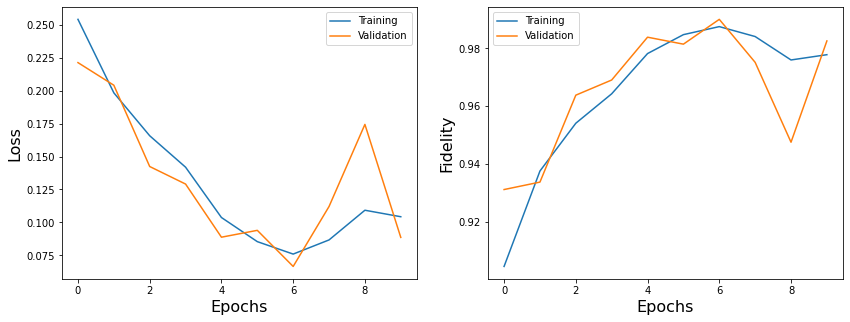

In [10]:
epochs = range(len(loss_epochs))

fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs,loss_epochs, label='Training')
ax1.plot(epochs,val_loss_epochs, label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.legend()

ax2.plot(epochs,fidelity_epochs, label='Training')
ax2.plot(epochs,val_fidelity_epochs, label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Fidelity', size=16)
ax2.legend()
plt.show()

In [ ]:
# Saving results
save = False
if save:
  np.savetxt('Results/TAE/TAE_Fidelity.txt', fidelity_epochs)
  np.savetxt('Results/TAE/TAE_Loss.txt', loss_epochs)
  np.savetxt('Results/TAE/val_TAE_Fidelity.txt', val_fidelity_epochs)
  np.savetxt('Results/TAE/val_TAE_Loss.txt', val_loss_epochs)